This notebook implements a finite element method (FEM) solver for the 1D nonlinear Schrödinger equation
\begin{align*}
i\partial_t\psi(x, t) = H[\Psi]\psi(x, t),\quad H[\Psi] = -\frac{1}{2m} \partial_x^2 + \nu_0|\Psi(x, t)|^2 + V(x),
\end{align*}
where $m$ is a positive constant (the mass), $\nu_0$ is a real constant ($\nu_0 > 0$ corresponds to repulsive interaction, and $\nu_0 < 0$ to attractive interaction), and $V(x) = \frac{1}{2}m V_\omega x^2 = \frac{1}{2} k x^2$ is a harmonic trapping potential with a force constant $k$.
The ground state of the system is solved from the time-independent version of the above equation, which is first transformed into weak form
\begin{align*}
\langle H[\Psi]\Psi, v \rangle &= \langle E\Psi, v \rangle,
\end{align*}
which is required to hold for each test function $v$ belonging to a suitable test space.
The wavefunction, $\Psi$, is then expanded in a finite basis $\{\phi_i\}$ (in this case, this basis also spans the test space) so that we can express $\Psi$ as $\Psi = \sum_i c_i \phi_i$ for some complex constants $c_i$. This results in a system of nonlinear equations
\begin{align*}
A[c]c = 0
\end{align*}
where $A_{ij} = 2m\nu_0 \sum_{k,l} c_k^* (I_4)_{ijkl} c_l - 2mE(I_2)_{ij} + J_{ij} + V_{ij}$,
\begin{align*}
(I_2)_{ij} = \int_\Omega \phi_i(x) \phi_j(x)\, dx, \quad
(I_4)_{ijkl} = \int_\Omega \phi_i(x) \phi_j(x)\phi_k(x) \phi_l(x)\, dx, \quad
J_{ij} = \int_\Omega \phi_i'(x) \phi_j'(x)\, dx, \quad
V_{ij} = \int_\Omega V(x) \phi_i(x) \phi_j(x)\, dx,
\end{align*}
and $\Omega$ is the simulation domain.
Here, the basis functions are second degree polynomials (see below for an illustration) and
the simulation domain consists of $N$ so-called elements, which each contain three basis functions. 
The latter fact induces a block structure to the resulting system of equations.

In addition to solving the stationary state(s), the notebook implements the split-step method for evolving the constants $c_i$ in time.
The weak form of the nonlinear Schrödinger equation gives rise to an equation for the coefficients $c_i$:
\begin{align*}
i\partial_t I_2c(t) = B[c(t)]c(t), \quad B_{ij}[c] = \nu_0 \sum_{k,l} c^*_k (I_4)_{ijkl} c_l + \frac{1}{2m} \left( J_{ij} + V_{ij} \right),
\end{align*}
which can be solved numerically by discretizing a desired time interval into steps of $\Delta t$
and computing the coefficients $c^{n}$ at time $t_n = n \Delta t$ using
\begin{align*}
c^{n} = e^{-i \bar{H}^n \Delta t} c^{n-1}, \quad \bar{H}^n = I_2^{-1} B[c^n].
\end{align*}
However, in this case no splitting is performed within a step and the operator exponential is computed by simply computing the matrix exponential of the discretized total "Hamiltonian".




N.B.: The implemented FEM solver imposes homogeneous boundary conditions and the split-step method imposes periodic boundary conditions.

In [15]:
%matplotlib inline
import numpy as np
from scipy import linalg
import sympy as sp
from sympy.tensor.array import MutableDenseNDimArray
from matplotlib import rcParams
import matplotlib.animation as anim
import matplotlib.pyplot as plt
from statistics import mean
from tqdm.auto import tqdm, trange
from IPython.display import Video

textplotsize = 8
rcParams['axes.labelsize']  = textplotsize
rcParams['xtick.labelsize'] = textplotsize
rcParams['ytick.labelsize'] = textplotsize
rcParams['legend.fontsize'] = textplotsize
rcParams['font.family'] = 'serif'
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Utilities

In [20]:
x = sp.symbols('x') # Spatial variable
e = sp.symbols('e') # Element index
basis_idx = sp.symbols('basis_idx')
one_half = sp.Rational(1, 2)

def bidx2eidx(i):
    return sp.floor(i/2)

phi_ref = [one_half*x*(x - 1), 1 - x**2, one_half*x*(x + 1)]

class FEM_grid:
    def __init__(self, start, end, element_count: int):
        assert(start < end)
        self.x0 = start
        self.xN = end
        self.dx = h = (end - start) / element_count
        self.N = element_count
        self.L = end - start
        self.basis_count = 2*element_count - 1

        x_e0 = self.x(e)
        x_e1 = self.x(e + 1)
        phi_e = [sp.Piecewise((2*(x - x_e0 - one_half*h)*(x - x_e1)/(h**2), (x_e0 <= x) & (x < x_e1)), (0, True)),
                 sp.Piecewise((-4*(x - x_e0)*(x - x_e1)/(h**2), (x_e0 <= x) & (x < x_e1)), (0, True)),
                 sp.Piecewise((2*(x - x_e0)*(x - x_e0 - one_half*h)/(h**2), (x_e0 <= x) & (x < x_e1)), (0, True))]
        phi = [phi_e[2].subs(e, bidx2eidx(basis_idx) - 1) + phi_e[0].subs(e, bidx2eidx(basis_idx)), # phi_2i  
               phi_e[1].subs(e, bidx2eidx(basis_idx))]                                              # phi_{2i+1}

        self.phi_e_ = phi_e
        self.phi_ = phi

    def x(self, i):
        #assert(i <= self.N)
        return self.x0 + i*self.dx
    
    def sample_x(self, point_count):
        return np.linspace(self.x0, self.xN, point_count)

    def phi(self, i): # Basis functions (i = 0, ..., 2N)
        return sp.lambdify(x, self.phi_[i & 1].subs(basis_idx, i), "numpy") 

# Gaussian elimination + backsubstitution for pentadiagonal matrices that don't require pivoting
def solve_pentadiag(a: np.array, b: np.array, c: np.array, d: np.array, e: np.array, RHS: np.array, x: np.array):
    n = len(c)
    assert(n >= 5)
    assert(n == len(RHS))
    assert(n == len(x))
    
    # Use these temp variables so that if the input arrays are aliased(e.g. symmetric system),
    # unrelated elements are not accidentally overwritten and the algorithm still works.
    a1 = a[0]
    b1 = b[0]
    b2 = b[1]

    # Eliminate
    for i in range(1, n-1):
        a1 = a[i-1]
        b2 = b[i]
        # Do row/equation i
        row_scale = b1/c[i-1]
        c[i] -= row_scale*d[i-1]
        d[i] -= row_scale*e[i-1]
        RHS[i] -= row_scale*RHS[i-1]

        # Do row/equation i + 1
        row_scale = a1/c[i-1]
        b1 = b2 - row_scale*d[i-1] 
        c[i+1] -= row_scale*e[i-1]
        RHS[i+1] -= row_scale*RHS[i-1]

    row_scale = b1/c[n-2]
    c[n-1] -= row_scale*d[n-2]
    RHS[n-1] -= row_scale*RHS[n-2]

    # Back substitute
    x[n-1] = RHS[n-1]/c[n-1]
    x[n-2] = (RHS[n-2] - d[n-2]*x[n-1])/c[n-2]
    for i in range(n-3, -1, -1):
        x[i] = (RHS[i] - d[i]*x[i+1] - e[i]*x[i+2])/c[i]


# Input: 
#   d0 - diagional
#   d1 - superdiagonal
#     ...
def solve_symmetric_pentadiag(d0: np.array, d1: np.array, d2: np.array, RHS: np.array, x: np.array):
    solve_pentadiag(d2, d1, d0, d1, d2, RHS, x)

def trial_norm_sq(c, gram):
    return (c.conj()@gram@c).real

def compute_energy(c, gram, A, m, test_idx = 0):
    return (0.5/(m*np.sum(gram[test_idx, :]*c))*np.sum(A[test_idx, :]*c)).real

def normalize(c, I2):
    psi_norm_sq = trial_norm_sq(c, I2)
    c[:] /= np.sqrt(psi_norm_sq)

def compute_G_matrix(G, I4_e, c, fem_grid):
    c_e = c[:2]
    G[:2, :2] += c_e.conj()@I4_e[1:, 1:, 1:, 1:]@c_e
    c_e = c[-2:]
    G[-2:, -2:] += c_e.conj()@I4_e[:-1, :-1, :-1, :-1]@c_e
    for eidx in range(1, fem_grid.N - 1):
        bidx = 2*eidx - 1
        c_e = c[bidx:bidx+3]
        G[bidx:bidx+3, bidx:bidx+3] += c_e.conj()@I4_e@c_e

def PIB_gs(x, m, h):
    return np.sqrt(2.0/h)*np.sin(np.pi*x/h)

def PIB_E(n, m, h):
    return (np.pi*n)**2/(2.0*m*h**2)

def HO_E(n, V_w):
    return V_w*(n + 0.5)

def HO_potential(x, k):
    return 0.5*k*x**2

def HO_gs(x, m, V_w):
    return np.sqrt(np.sqrt(m*V_w/np.pi))*np.exp(-0.5*m*V_w*x**2)

def psi(x, c, fem_grid):
    return sum(c_i*fem_grid.phi(i + 1)(x) for i, c_i in enumerate(c))

## Basis functions

(0.0, 6.0)

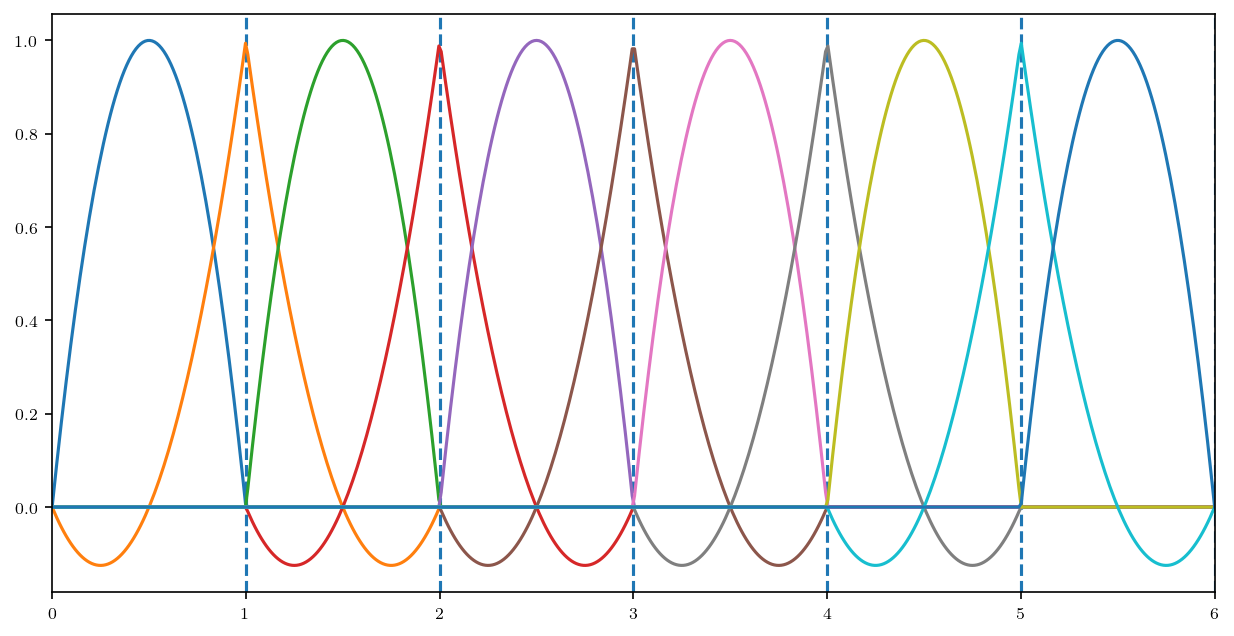

In [21]:
h = 6
N = 6
basis_count = 2*N - 1
fem_grid = FEM_grid(0, h, N)

plot_x = fem_grid.sample_x(500)
fig, ax = plt.subplots(figsize = (10, 5), dpi = 150)

for i in range(1, N + 1):
    ax.axvline(fem_grid.x(i), linestyle = "--")

for i in range(1, basis_count + 1):
    plot_phi = fem_grid.phi(i)
    ax.plot(plot_x, plot_phi(plot_x))
    
ax.set_xlim([fem_grid.x0, fem_grid.xN])

## Parameters

In [22]:
h = 6 # Defines the solution domain [0, h] 
N = 30 
fem_grid = FEM_grid(0, h, N)
basis_count = fem_grid.basis_count

# Physical parameters
m  = 1.0
k = 4.0
V_w = np.sqrt(k/m)
v0 = 1.0 

itr_count = 2000
w = 2/3

float_bits = 64

## Integrals and assembly

In [26]:
def assemble_matrices(fem_grid, m, V_w):
    basis_count = fem_grid.basis_count
    N = fem_grid.N
    h = fem_grid.L

    I2 = np.zeros((basis_count, basis_count), dtype = f"float{float_bits}") 
    J  = np.zeros_like(I2)
    V  = np.zeros_like(I2)
    I4_e = np.zeros([3]*4, dtype = f"float{float_bits}")
    II, JJ = np.indices(I2.shape)

    # "4-particle" integrals
    def I4_ref(i, j, k, l): # i, j, k, l = 0, 1, 2
        return sp.integrate(phi_ref[i]*phi_ref[j]*phi_ref[k]*phi_ref[l], (x, -1, 1))

    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    I4_e[i, j, k, l] = I4_ref(i, j, k, l)
    

    # "2-particle" integrals
    # Diagonal
    I2.ravel()[::2*(basis_count + 1)] = 16
    I2.ravel()[basis_count+1::2*(basis_count + 1)] = 8
    # Superdiagonal
    I2[II == (JJ + 1)] = 2
    I2[II == (JJ - 1)] = 2
    # Super superdiagonal
    I2.ravel()[(basis_count + 3):-2*basis_count:2*(basis_count + 1)] = -1
    I2.ravel()[3*basis_count + 1::2*(basis_count + 1)] = -1

    # "2-particle" integrals of differentiated basis functions
    # Diagonal
    J.ravel()[::2*(basis_count + 1)] = 16
    J.ravel()[basis_count+1::2*(basis_count + 1)] = 14
    ## Superdiagonal
    J[II == (JJ + 1)] = -8
    J[II == (JJ - 1)] = -8
    # Super superdiagonal
    J.ravel()[(basis_count + 3):-2*basis_count:2*(basis_count + 1)] = 1
    J.ravel()[3*basis_count + 1::2*(basis_count + 1)] = 1

    # Potential integrals 
    temp = np.zeros((3, 3), dtype = np.float32)
    def V_e_prefixless(result, element_idx):
        x_e = fem_grid.x(element_idx)
        d = fem_grid.dx
        L = h
        result[0, 0] = (1/210)*(56.0*x_e**2 + 14.0*x_e*(d - 4.0*L) + 2.0*d**2 - 7.0*d*L + 14.0*L**2)
        result[1, 1] = (4/105)*(28.0*x_e**2 + 28.0*x_e*(d - L) + 8.0*d**2 - 14.0*d*L + 7.0*L**2)
        result[2, 2] = (1/210)*(56.0*x_e**2 + 98.0*x_e*d - 56.0*x_e*L + 44.0*d**2 - 49.0*d*L + 14.0*L**2)
        result[0, 1] = result[1, 0] = (1/210)*(28.0*x_e**2 - 28.0*x_e*L - 4.0*d**2 + 7.0*L**2)
        result[0, 2] = result[2, 0] = (1/420)*(-28.0*x_e**2 - 28.0*x_e*(d - L) - 10.0*d**2 + 14.0*d*L - 7.0*L**2)
        result[1, 2] = result[2, 1] = (1/210)*(28.0*x_e**2 + 56.0*x_e*d - 28.0*x_e*L + 24.0*d**2 - 28.0*d*L + 7.0*L**2)
        return result

    V[:2, :2] += V_e_prefixless(temp, 0)[1:, 1:]
    V[-2:, -2:] += V_e_prefixless(temp, N - 1)[:-1, :-1]
    for eidx in range(1, N - 1):
        bidx = 2*eidx - 1
        V[bidx:bidx+3, bidx:bidx+3] += V_e_prefixless(temp, eidx)
 
    I2 *= fem_grid.dx/30
    I4_e *= 0.5*fem_grid.dx
    J *= 1.0/(3.0*fem_grid.dx)
    V *= 0.5*fem_grid.dx*(0.5*m*V_w**2)

    return I2, I4_e, J, V

## Stationary state(s) - Jacobi overrelaxation

In [27]:
def JOR_solve(I2, I4_e, J, V, fem_grid, m, v0, itr_count, w = 2/3):
    basis_count = fem_grid.basis_count
    A = np.zeros((basis_count, basis_count), dtype = f"complex{2*float_bits}")  
    D = np.zeros(basis_count, dtype = f"complex{2*float_bits}")
    G = np.zeros_like(A)
    c = np.ones(basis_count, dtype = f"complex{2*float_bits}")  
    normalize(c, I2)

    energies = []

    with trange(itr_count) as pbar: 
        for i in pbar:
            G[:] = 0
            compute_G_matrix(G, I4_e, c, fem_grid)

            A[:] = 2.0*m*(v0*G + V) + J 
            # NOTE: This assumes that the energy is valid/defined for each test index
            E = mean(compute_energy(c, I2, A, m, test_idx = eidx) for eidx in range(basis_count)) 
            A[:] -= 2.0*m*E*I2

            D[:] = np.diag(A)

            c[:] = c - w*((1.0/D)*(A@c))
            normalize(c, I2)

            energies.append(E)
            pbar.set_postfix(E = f"{E:.6e}")
    
    G[:] = 0
    compute_G_matrix(G, I4_e, c, fem_grid)
    A[:] = 2.0*m*(v0*G + V) + J 
    test_energies = [compute_energy(c, I2, A, m, test_idx = tidx) for tidx in range(basis_count)]
    
    A[:] -= 2.0*m*mean(test_energies)*I2
    max_error = np.abs(A@c).max()

    del A, D, G
    return c, energies, test_energies, max_error

In [28]:
I2, I4_e, J, V = assemble_matrices(fem_grid, m, V_w)
c, energies, test_energies, max_error = JOR_solve(I2, I4_e, J, V, fem_grid, m, v0, 2000, w)
E = energies[-1]
print(f"Max error: {max_error:.4e}")

100%|██████████| 2000/2000 [00:02<00:00, 953.48it/s, E=1.534095e+00]

Max error: 1.7764e-15


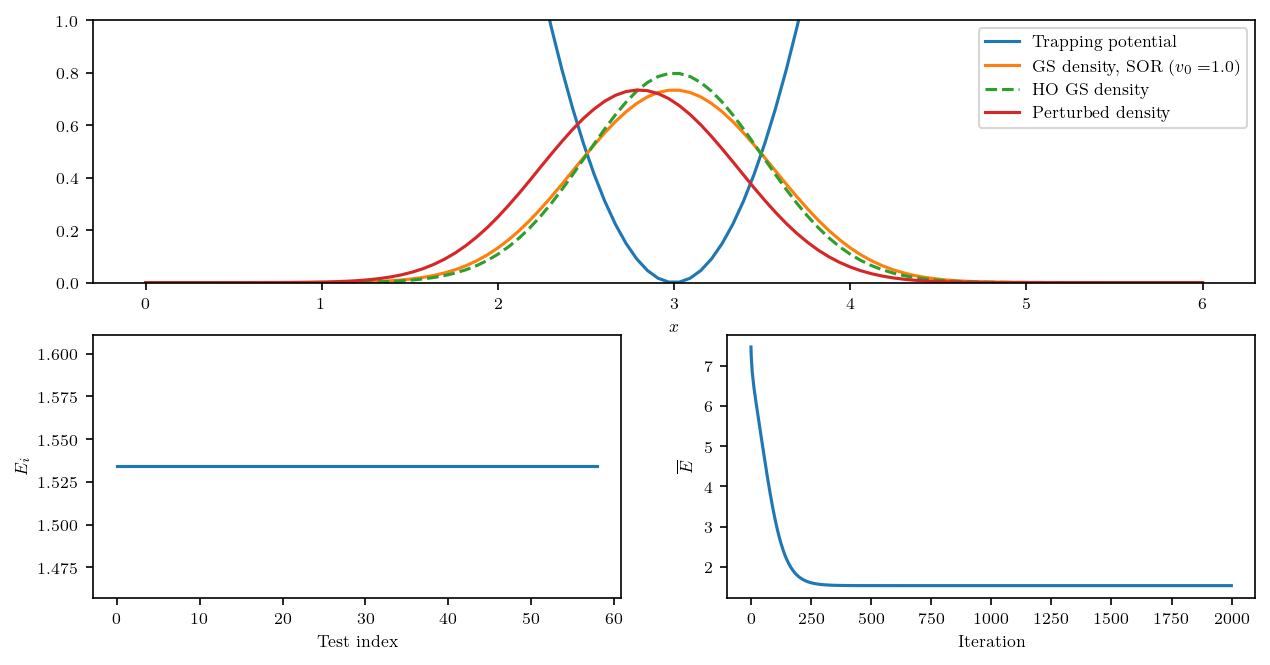

In [29]:
fig = plt.figure(figsize = (10, 5), dpi = 150)

ax = fig.add_subplot(224)
ax.plot(list(range(len(energies))), energies)
ax.set_xlabel("Iteration")
ax.set_ylabel(r"$\overline{E}$")

ax = fig.add_subplot(223)
ax.plot(list(range(basis_count)), test_energies) # These should all be approximately equal
ax.set_xlabel("Test index")
ax.set_ylim([0.95*E, 1.05*E])
ax.set_ylabel("$E_i$")

plot_x = fem_grid.sample_x(100)
c_perturbed = np.zeros_like(c)
c_perturbed[:-2] = c[2:]
normalize(c_perturbed, I2)

ax = fig.add_subplot(211)
ax.plot(plot_x, HO_potential(plot_x - 0.5*h, k), label = f"Trapping potential")
ax.plot(plot_x, np.abs(psi(plot_x, c, fem_grid))**2, label = f"GS density, FEM ($v_0 = ${v0})")
ax.plot(plot_x, np.abs(HO_gs(plot_x - 0.5*h, m, V_w))**2, linestyle = '--', label = "HO GS density")
ax.plot(plot_x, np.abs(psi(plot_x, c_perturbed, fem_grid))**2, label = f"Perturbed density")
#ax.set_xlim([1, 5])
ax.set_ylim([0, 1])
ax.set_xlabel("$x$")
ax.legend()

## Time-evolution

In [30]:
def split_step(I2, I4_e, J, V, fem_grid, m, v0, c0, dt, step_count):
    basis_count = fem_grid.basis_count
    c_t = c0
    coeffs = [c_t]

    G = np.zeros((basis_count, basis_count), dtype = f"complex{2*float_bits}")
    H = np.zeros_like(G)
    I2_inv = linalg.inv(I2)

    with trange(step_count) as pbar: 
        for i in pbar:
            G[:] = 0
            compute_G_matrix(G, I4_e, c_t, fem_grid)

            H[:] = I2_inv@(v0*G + V + 0.5*J/m)
            expH = linalg.expm(-1.0j*dt*H)
            c_t = expH@c_t

            coeffs.append(c_t)

            psi_norm_sq = trial_norm_sq(c_t, I2)
            pbar.set_postfix(norm_sq = f"{psi_norm_sq:.6f}", t = f"{i*dt:2e}")

    del G, H
    return coeffs

In [31]:
coeffs = split_step(I2, I4_e, J, V, fem_grid, m, v0, c_perturbed.copy(), 1e-3, 10000)

100%|██████████| 10000/10000 [02:09<00:00, 77.09it/s, norm_sq=1.000000, t=9.999000e+00]


In [32]:
fig, ax = plt.subplots(dpi = 150)
ax.plot(plot_x, HO_potential(plot_x - 0.5*h, k), label = f"Trapping potential")
psi_plot, = ax.plot(plot_x, np.abs(psi(plot_x, coeffs[0], fem_grid))**2, label = f"$|\Psi|^2$ ($v_0 = ${v0}, $V_w = ${V_w})")
ax.set_xlim([1.5, 4.5])
ax.set_ylim([0, 1])
ax.set_xlabel("$x$")
ax.legend(loc = 'upper right')

def animate_plot(t_idx):
    psi_t = psi(plot_x, coeffs[t_idx], fem_grid)
    psi_plot.set_ydata((psi_t.conj()*psi_t).real)
    return psi_plot,

anim.FuncAnimation(fig, animate_plot, frames = np.arange(len(coeffs), step = 10), interval = 10).save("density_evolution.mp4")
plt.close()

In [35]:
Video("density_evolution.mp4")

## Tests

This section tries to assess the correctness of the solver
(currently does not include any comparisons to exact solutions of the 1D nonlinear Schrödinger equation in the case when 
$v_0 \ne 0$).

### Particle in a box ($v_0 = V_w = 0$)

100%|██████████| 10000/10000 [00:16<00:00, 595.16it/s, E=1.713475e-02]


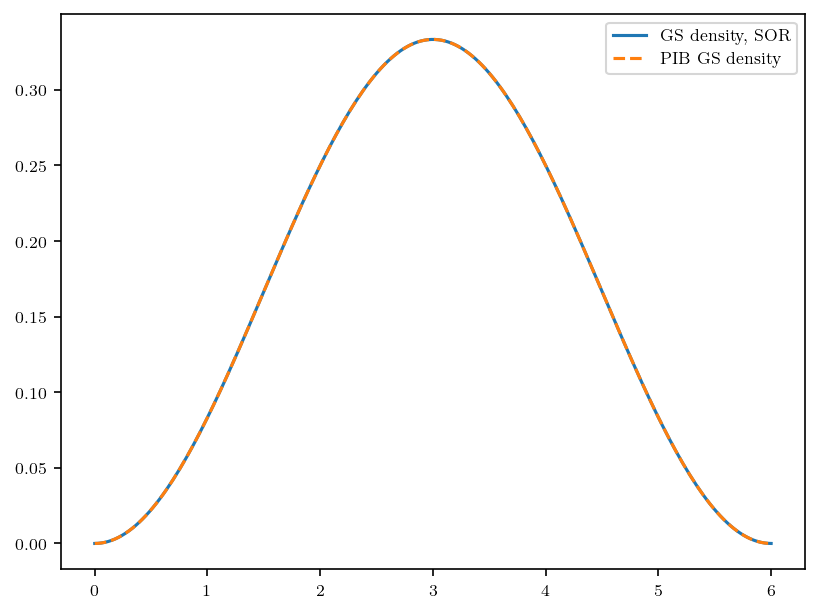

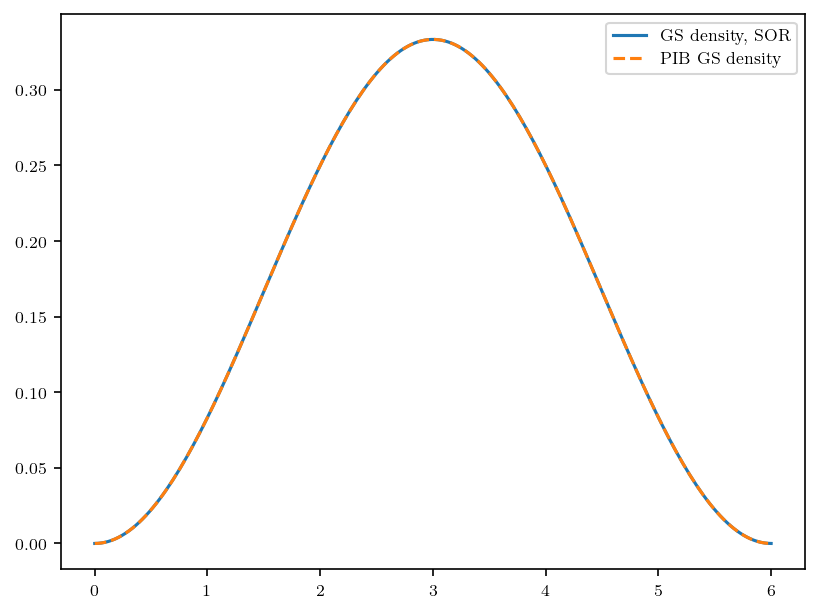

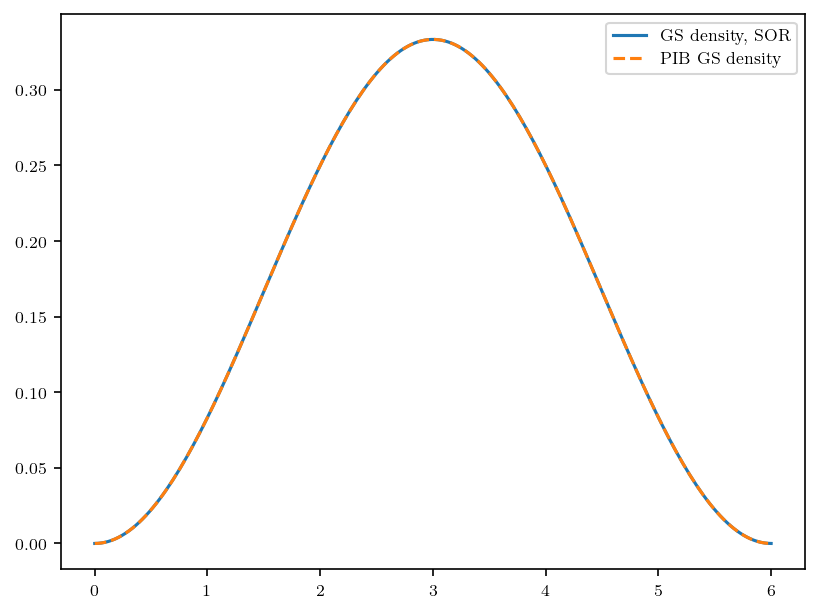

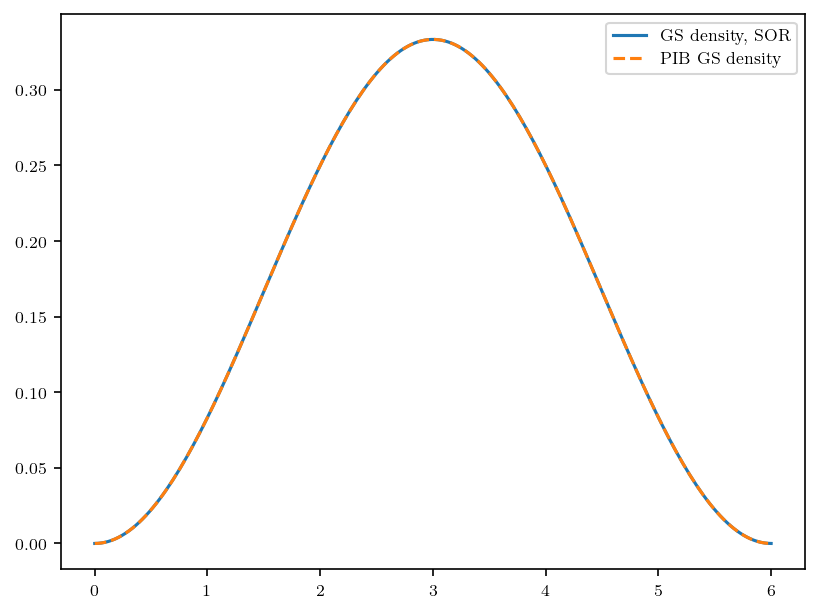

In [33]:
def test_PIB(m, fem_grid, itr_count, w, error_threshold):
    v0 = 0
    V_w = 0
    I2, I4_e, J, V = assemble_matrices(fem_grid, m, V_w)
    c, energies, test_energies, max_error = JOR_solve(I2, I4_e, J, V, fem_grid, 
                                                      m = m, v0 = v0, itr_count = itr_count, w = w)
    E = energies[-1]
    test_x = fem_grid.sample_x(200)
    assert(np.isclose(E, PIB_E(1, m, fem_grid.L), atol = error_threshold))
    assert(max_error < error_threshold)

    fig, ax = plt.subplots(dpi = 150)
    ax.plot(test_x, np.abs(psi(test_x, c, fem_grid))**2, label = f"GS density, FEM") 
    ax.plot(test_x, np.abs(PIB_gs(test_x, m, fem_grid.L))**2, label = "PIB GS density", linestyle = '--')
    ax.legend()

h = 6 
N = 60
fem_grid = FEM_grid(0, h, N)
basis_count = fem_grid.basis_count

itr_count = 10000
w = 2/3
error_threshold = 1e-4

test_PIB(1.0, fem_grid, itr_count, w, error_threshold)
test_PIB(2.0, fem_grid, itr_count, w, error_threshold)
test_PIB(4.0, fem_grid, itr_count, w, error_threshold)
test_PIB(8.0, fem_grid, itr_count, w, error_threshold)

### Harmonic oscillator ($v_0 = 0$)

100%|██████████| 5000/5000 [00:12<00:00, 401.69it/s, E=1.118039e+01]


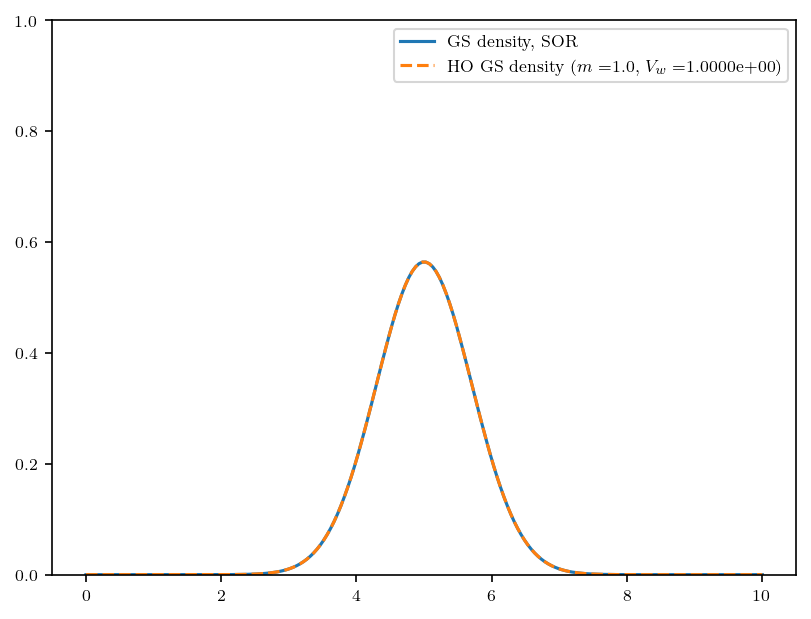

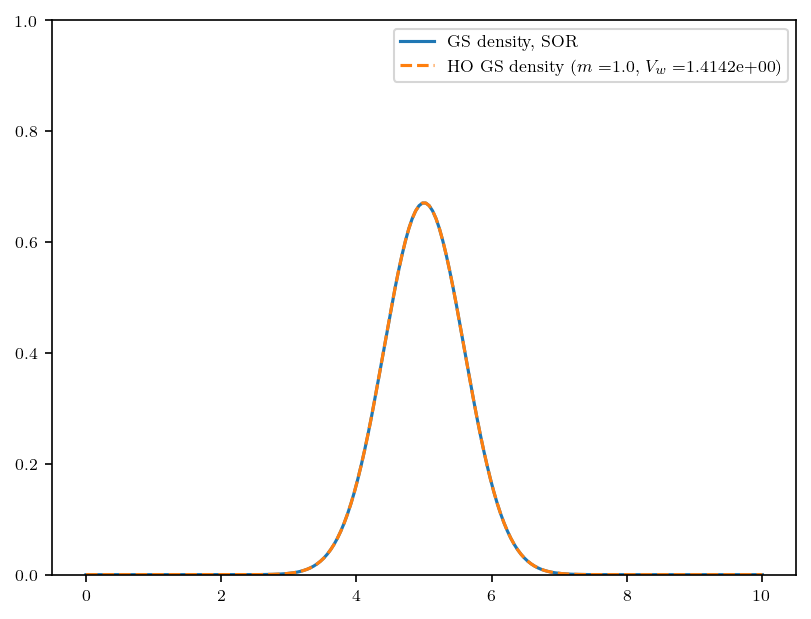

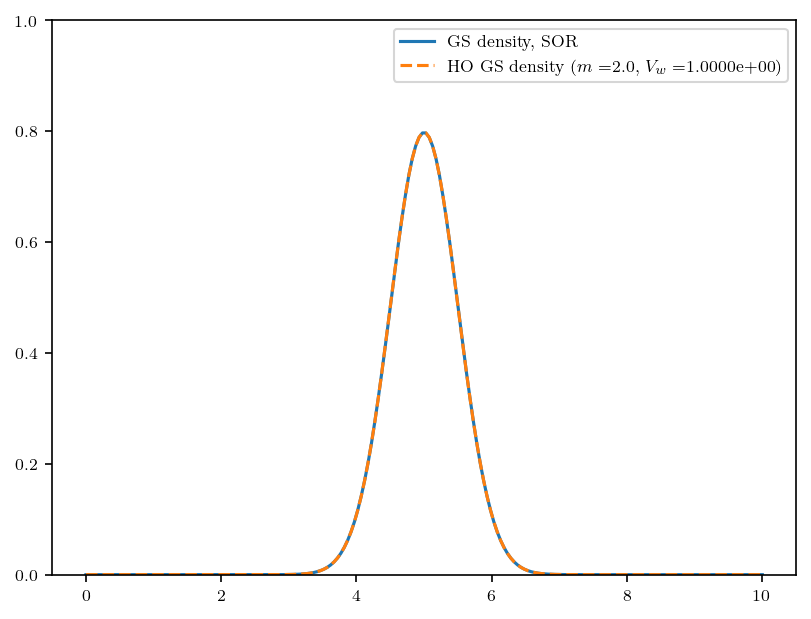

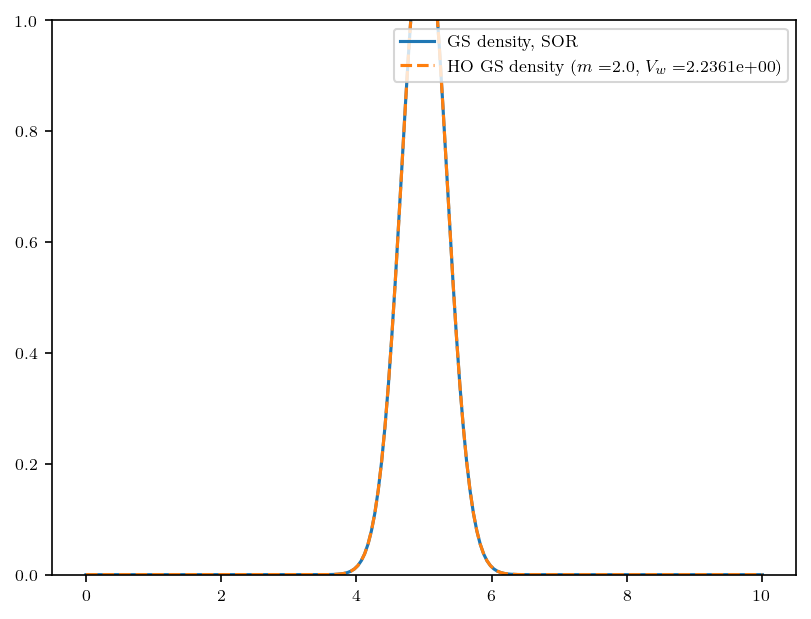

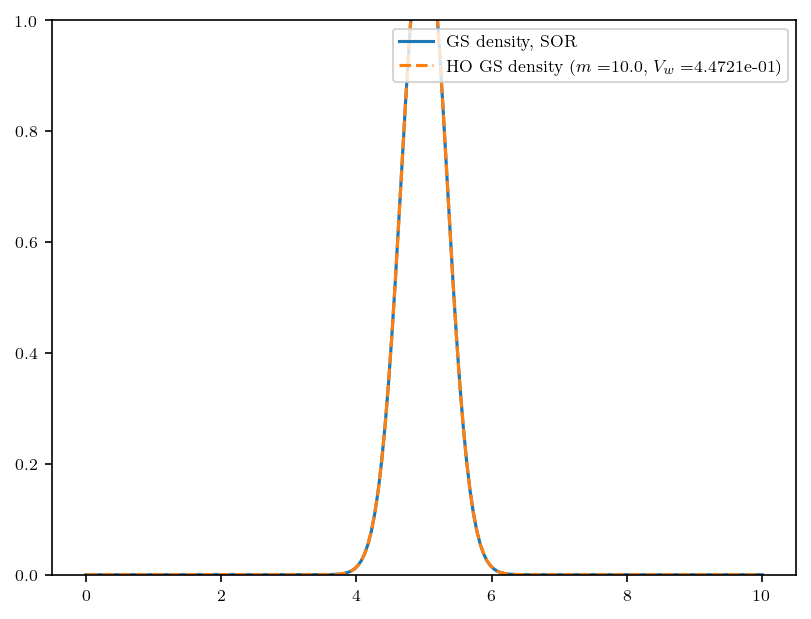

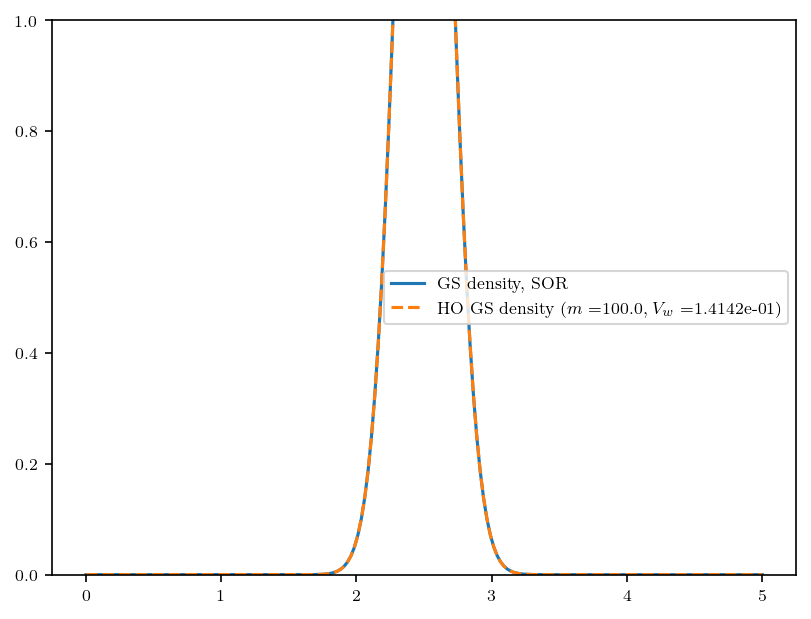

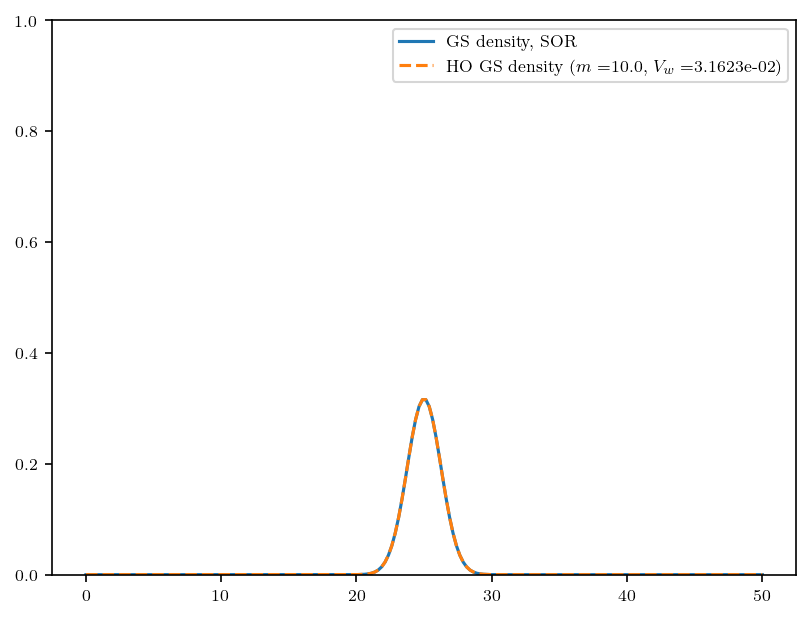

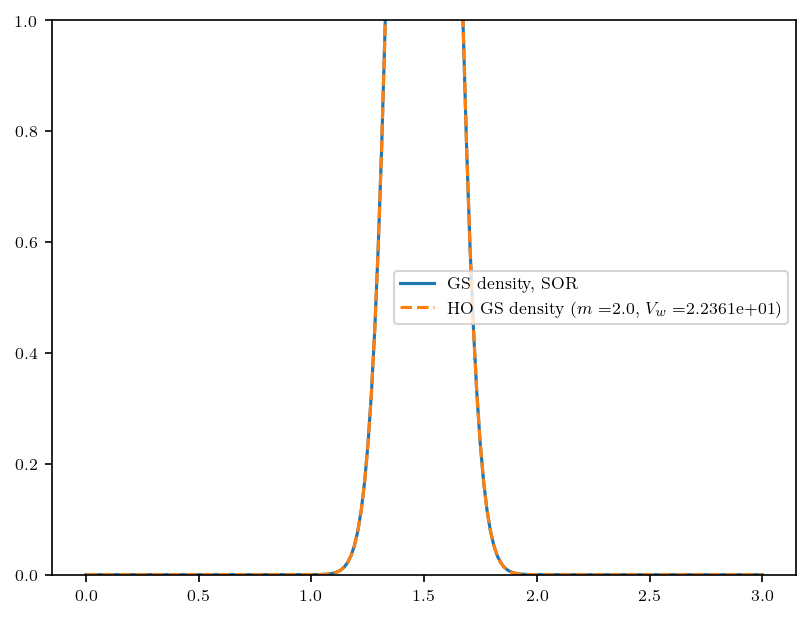

In [34]:
def test_HO(m, k, fem_grid, itr_count, w, error_threshold, plot_potential = False):
    v0 = 0.0
    V_w = np.sqrt(k/m)
    I2, I4_e, J, V = assemble_matrices(fem_grid, m, V_w)
    c, energies, test_energies, max_error = JOR_solve(I2, I4_e, J, V, fem_grid, 
                                                      m = m, v0 = v0, itr_count = itr_count, w = w)

    E = energies[-1]
    test_x = fem_grid.sample_x(200)
    assert(np.isclose(E, HO_E(0, V_w), atol = error_threshold))
    assert(max_error < error_threshold)

    fig, ax = plt.subplots(dpi = 150)
    ax.plot(test_x, np.abs(psi(test_x, c, fem_grid))**2, label = f"GS density, FEM") 
    ax.plot(test_x, np.abs(HO_gs(test_x - 0.5*fem_grid.L, m, V_w))**2, label = f"HO GS density ($m = ${m}, $V_w = ${V_w:.4e})", linestyle = '--')
    if plot_potential:
        ax.plot(test_x, HO_potential(test_x - 0.5*fem_grid.L, k), label = 'Trapping potential')
    ax.set_ylim([0, 1])
    ax.legend()

h = 10
N = 40
fem_grid = FEM_grid(0, h, N)
basis_count = fem_grid.basis_count

w = 2/3
error_threshold = 1e-4

itr_count = 2000
test_HO(1.0, 1.0, fem_grid, itr_count, w, error_threshold)
test_HO(1.0, 2.0, fem_grid, itr_count, w, error_threshold)
test_HO(2.0, 2.0, fem_grid, itr_count, w, error_threshold)

itr_count = 5000
##test_HO(2.0, 100.0, FEM_grid(0, 20, 300), itr_count, w, error_threshold)
test_HO(2.0, 10.0, FEM_grid(0, 10, 100), itr_count, w, error_threshold)
test_HO(10.0, 2.0, FEM_grid(0, 10, 100), itr_count, w, error_threshold)
test_HO(100.0, 2.0, FEM_grid(0, 5, 100), itr_count, w, error_threshold)
test_HO(10.0, 1e-2, FEM_grid(0, 50, 256), itr_count, w, error_threshold)
test_HO(2.0, 1e3, FEM_grid(0, 3, 100), itr_count, w, error_threshold)